In [1]:
import numpy as np
import xarray as xr
import datetime as dt
import os
import matplotlib.pyplot as plt

In [3]:
is_detrend= 1 #1 to use detrended anomalies (default), 0 otherwise

In [4]:
# Years to process and years to use as climatology for thresholds
years = [1991, 2020]
clim_years = [1991, 2020]

basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
# Input/output directory
if is_detrend:
    dir_in = basepath+'/anomaly/detrended';
    dir_out = basepath+'/mhw/detrended';
else:
    dir_in = basepath+'/anomaly'
    dir_out = basepath+'/mhw'
if not os.path.exists(dir_out):
    os.makedirs(dir_out)
    

# Model names
#           1              2               3            4              5             6
mods = ['CanCM4i', 'COLA-RSMAS-CCSM4', 'GEM-NEMO', 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2']#
nmod = len(mods)
nl = dict(zip(mods,[11, 11, 11, 11, 8, 9])) # Max lead time for each model
#mods = [ 'GFDL-SPEAR', 'NASA-GEOSS2S', 'NCEP-CFSv2']#

In [5]:
# Loop through models
print('\nIdentifying MHWs for NMME forecasts...\n')
for modi in mods:
    
    print(f'\nProcessing {modi}...\n')
    print( 'Lead')
    
    # Loop through lead times
    for il in range(0,nl[modi]):
        print(' ',il)
        
        # Load anomalies        
        if is_detrend:
            f_in = f'{dir_in}/sst_{modi}_l{il}_anomaly_detrended_{years[0]}_{years[1]}.nc'
            fin=xr.open_dataset(f_in)
            sst_an=fin.sst_an_dt.values
        else:
            f_in = f'{dir_in}/sst_{modi}_l{il}_anomaly_{years[0]}_{years[1]}.nc'
            fin=xr.open_dataset(f_in)
            sst_an=fin.sst_an.values
        month=fin.month.values
        year=fin.year.values
        
        # Loop through month and compute sst anomaly thresholds for MHWs
        # Thresholds are computed with a 3-month moving window
        sst_an_thr=np.zeros((12,len(fin.Y),len(fin.X)))
        for ii in range(1,13): # month
            if ii==1:
                tind = ((month==12) | (month<=2)) & (year>=clim_years[0]) & (year<=clim_years[1])
            elif ii==12:
                tind = ((month==1) | (month>=11)) & (year>=clim_years[0]) & (year<=clim_years[1])
            else:
                tind = (month>=ii-1) & (month<=ii+1) & (year>=clim_years[0]) & (year<=clim_years[1])
            tmp = sst_an[tind,...]
            nt,nm,ny,nx = np.shape(tmp);
            tmp=tmp.reshape(nm*nt,ny,nx) # Pool all members/initializations for each grid cell
            sst_an_thr[ii-1,...] = np.quantile(tmp,0.9,axis=0)
        
        # Find points that exceed thresholds
        is_mhw=np.zeros(np.shape(sst_an))
        nt,nm,ny,nx=np.shape(sst_an)
        for ii in range(0,nt):
            mm=month[ii]
            is_mhw[ii,...]=np.where(sst_an[ii,...]>np.expand_dims(sst_an_thr[mm-1,...],0),1,0)
            # for im in range(0,nm):
            #     tmp = np.zeros(ny,nx)
            #     tmp(sst_an(:,:,im,ii)>sst_an_thr(:,:,month(ii)))= 1;
            #     tmp(isnan(sst_an(:,:,im,ii))) = nan;
            #     is_mhw(:,:,im,ii) = tmp;
  
        
        # Find forecast MHW probability
        mhw_prob = np.squeeze(np.nanmean(is_mhw,axis=1))
        
        # Save to file
        if is_detrend:
            f_out = f'{dir_out}/mhw_{modi}_l{il}_detrended_{years[0]}_{years[1]}.nc'
        else:
            f_out = f'{dir_out}/mhw_{modi}_l{il}_{years[0]}_{years[1]}.nc'
        xout=xr.Dataset(data_vars={'lon':(['X',],fin.lon.values),
                            'lat':(['Y',],fin.lat.values),
                            'time':(['S'],fin.time.values),
                            'year':(['S'],fin.year.values),
                            'month':(['S'],fin.month.values),
                            'sst_an_thr':(['Mon','Y','X'],sst_an_thr),
                            'is_mhw':(['S','M','Y','X'],is_mhw),
                            'mhw_prob':(['S','Y','X'],mhw_prob)},
                coords=dict(X=fin.X,Y=fin.Y,M=fin.M,S=fin.S,Mon=("Mon",np.arange(1,13))),)
        xout.to_netcdf(f_out,mode='w')
        fin.close()
        del sst_an_thr; del is_mhw; del mhw_prob;
print('\nDone\n\n')


Identifying MHWs for NMME forecasts...


Processing CanCM4i...

Lead
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
  10

Processing COLA-RSMAS-CCSM4...

Lead
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
  10

Processing GEM-NEMO...

Lead
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
  10

Processing GFDL-SPEAR...

Lead
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
  10

Processing NASA-GEOSS2S...

Lead
  0
  1
  2
  3
  4
  5
  6
  7

Processing NCEP-CFSv2...

Lead
  0
  1
  2
  3
  4
  5
  6
  7
  8

Done




In [6]:
test=xr.open_dataset(f_out)
test

<xarray.Dataset> Size: 5GB
Dimensions:     (X: 360, Y: 181, S: 360, Mon: 12, M: 24)
Coordinates:
  * X           (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y           (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * M           (M) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * S           (S) float32 1kB 372.0 373.0 374.0 375.0 ... 729.0 730.0 731.0
  * Mon         (Mon) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lon         (X) float32 1kB ...
    lat         (Y) float32 724B ...
    time        (S) float32 1kB ...
    year        (S) int64 3kB ...
    month       (S) int64 3kB ...
    sst_an_thr  (Mon, Y, X) float64 6MB ...
    is_mhw      (S, M, Y, X) float64 5GB ...
    mhw_prob    (S, Y, X) float64 188MB ...

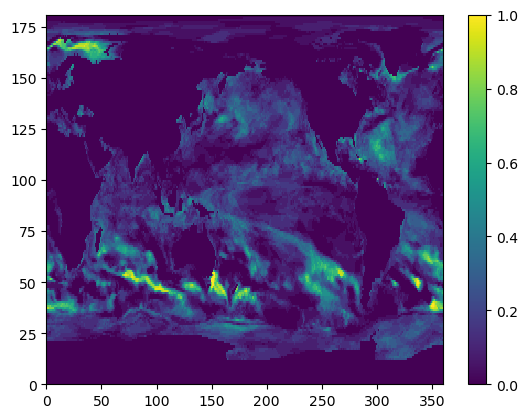

In [7]:
plt.pcolormesh(test.mhw_prob[0,:,:])
plt.colorbar()

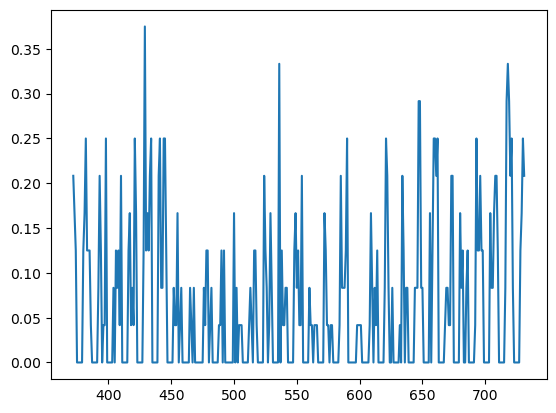

In [8]:
plt.plot(test.time,test.mhw_prob[:,140,200])

In [9]:
test.close()